<a href="https://colab.research.google.com/github/Sachinr-007/Movies-Recommmendation-System/blob/main/Movie_Recommendation_System_using_huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading Important libraries and requirements

In [ ]:
!pip install transformers
!pip install sentence_transformers
!pip install faiss-cpu
!pip install gradio
!pip install sentence-transformers
!pip install huggingface_hub
"""!pip install transformers==4.26.0
!pip install sentence-transformers==2.3.0 # Trying a slightly newer version
!pip install huggingface_hub==0.13.0"""

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.8/23.8 MB 66.2 MB/s eta 0:00:00


'!pip install transformers==4.26.0\n!pip install sentence-transformers==2.3.0 # Trying a slightly newer version\n!pip install huggingface_hub==0.13.0'

Login into Hugging face So we can use different LLM models

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
"""import pandas as pd
import numpy as np
import json
from transformers import AutoTokenizer
import transformers
import torch


model = "meta-llama/Llama-2-7b-hf"

tokenizer = AutoTokenizer.from_pretrained(model,user_auth_token=True)"""

'import pandas as pd\nimport numpy as np\nimport json\nfrom transformers import AutoTokenizer\nimport transformers\nimport torch\n\n\nmodel = "meta-llama/Llama-2-7b-hf"\n\ntokenizer = AutoTokenizer.from_pretrained(model,user_auth_token=True)'

Importing dependencies

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import transformers
import faiss

Reading Dataset into a Dataframe

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/netflix_titles.csv')

First five rows of the dataframe

In [ ]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [ ]:
df.isnull().sum()

,0
show_id,0
type,0
title,0
director,2634
cast,825
country,831
date_added,10
release_year,0
rating,4
duration,3


In [ ]:
df.type.unique()

array(['Movie', 'TV Show'], dtype=object)

In [ ]:
df.fillna("Unknown", inplace=True)

In [ ]:
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",Unknown,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


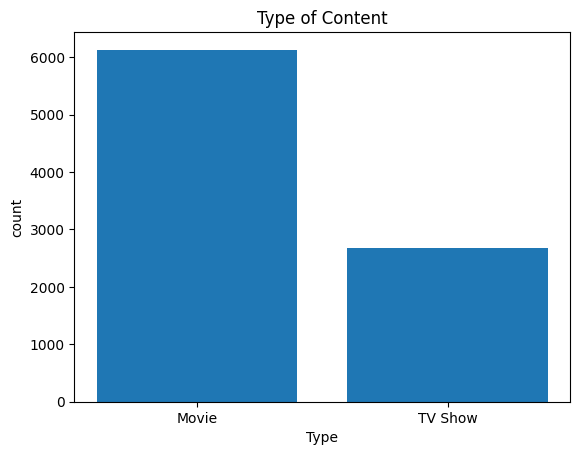

In [ ]:
plt.bar(df['type'].value_counts().index, df['type'].value_counts().values)
plt.title('Type of Content')
plt.xlabel('Type')
plt.ylabel('count')
plt.show()

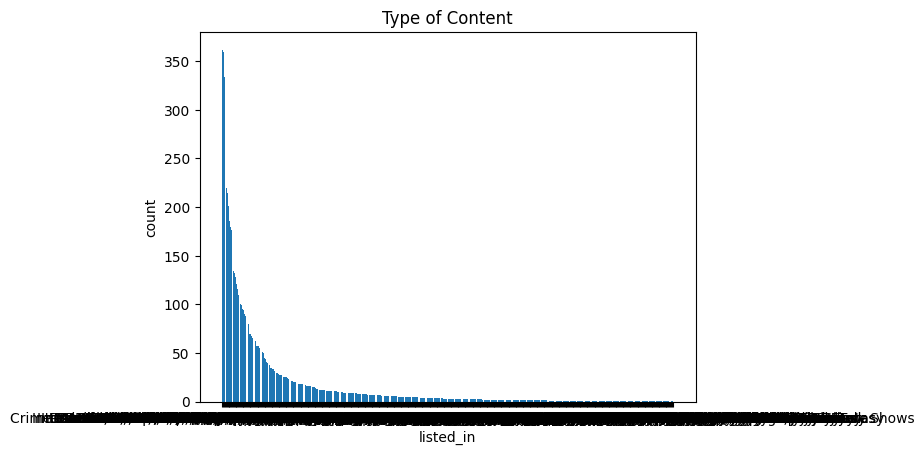

In [ ]:
plt.bar(df['listed_in'].value_counts().index, df['listed_in'].value_counts().values)
plt.title('Type of Content')
plt.xlabel('listed_in')
plt.ylabel('count')
plt.show()

In [ ]:
df.shape

(8807, 12)

In [ ]:
# 2. Create textual representations (reuse your function)
def create_textual_representation(row):
  textual_representation = f"""Type: {row['type']},
  Title: {row['title']},
  Director: {row['director']},
  Cast: {row['cast']},
  Released: {row['release_year']},
  Genres: {row['listed_in']},

  Description: {row['description']}
  """
  return textual_representation

df['textual_representation'] = df.apply(create_textual_representation, axis=1)

In [ ]:
print(df['textual_representation'].values[0])

Type: Movie,
  Title: Dick Johnson Is Dead,
  Director: Kirsten Johnson,
  Cast: Unknown,
  Released: 2020,
  Genres: Documentaries,

  Description: As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.
  


Loading Model sentence-transformers/all-MiniLM-L6-v2

Here we have used faiss index. We could also use similar vector databases like chroma, pinecone, weaviate, or qdrant that work similarly, you just have to change the backend.

In [ ]:
# Load Hugging Face embedding model
embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Get embedding dimension
dim = embed_model.get_sentence_embedding_dimension()

# Initialize FAISS index
index = faiss.IndexFlatL2(dim)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Generate embeddings
X = []
for i, representation in enumerate(df['textual_representation']):
    if i % 30 == 0:
        print("Processed", str(i), "instances")
    embedding = embed_model.encode(representation, convert_to_numpy=True)
    X.append(embedding)

X = np.array(X, dtype="float32")
index.add(X)

Processed 0 instances
Processed 30 instances
Processed 60 instances
Processed 90 instances
Processed 120 instances
Processed 150 instances
Processed 180 instances
Processed 210 instances
Processed 240 instances
Processed 270 instances
Processed 300 instances
Processed 330 instances
Processed 360 instances
Processed 390 instances
Processed 420 instances
Processed 450 instances
Processed 480 instances
Processed 510 instances
Processed 540 instances
Processed 570 instances
Processed 600 instances
Processed 630 instances
Processed 660 instances
Processed 690 instances
Processed 720 instances
Processed 750 instances
Processed 780 instances
Processed 810 instances
Processed 840 instances
Processed 870 instances
Processed 900 instances
Processed 930 instances
Processed 960 instances
Processed 990 instances
Processed 1020 instances
Processed 1050 instances
Processed 1080 instances
Processed 1110 instances
Processed 1140 instances
Processed 1170 instances
Processed 1200 instances
Processed 1230

In [ ]:
# Save index
faiss.write_index(index, "index")

In [ ]:
# Encode favorite movie using Hugging Face (or hypothetical description)
favorite_movie = df.iloc[0]
# From here we point to any movies or tv show as our favorit_movie based on that the model will predict top 5 movies or tv shows
favorite_movie

,0
show_id,s1
type,Movie
title,Dick Johnson Is Dead
director,Kirsten Johnson
cast,Unknown
country,United States
date_added,"September 25, 2021"
release_year,2020
rating,PG-13
duration,90 min


In [ ]:
# Going through the processed embeddings
embedding = embed_model.encode(favorite_movie['textual_representation'], convert_to_numpy=True)
embedding = np.array([embedding], dtype="float32")

# Search FAISS index
D, I = index.search(embedding, 5)

# Get best matches
best_matches = np.array(df['textual_representation'])[I.flatten()]

# Print recommendations
for match in best_matches:
    print("Next Movie or Tv show: ")
    print(match)
    print()

Next Movie or Tv show: 
Type: Movie,
  Title: Dick Johnson Is Dead,
  Director: Kirsten Johnson,
  Cast: Unknown,
  Released: 2020,
  Genres: Documentaries,

  Description: As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.
  

Next Movie or Tv show: 
Type: Movie,
  Title: He Never Died,
  Director: Jason Krawczyk,
  Cast: Henry Rollins, Booboo Stewart, Kate Greenhouse, Jordan Todosey, David Richmond-Peck, James Cade, Don Francks, Steven Ogg,
  Released: 2015,
  Genres: Comedies, Horror Movies,

  Description: A reclusive immortal who needs human flesh but tries to stay clean finds himself cast back into society by a gang of thugs and his estranged daughter.
  

Next Movie or Tv show: 
Type: Movie,
  Title: The Death and Life of Marsha P. Johnson,
  Director: David France,
  Cast: Unknown,
  Released: 2017,
  Genres: Documentaries, LGBTQ Movies,

  Description: As she fights the tide o

## Create a recommendation function



In [ ]:
def get_recommendations(input_text: str):
    """
    Recommends movies based on an input movie title or description.

    Args:
        input_text: The movie title or description to get recommendations for.

    Returns:
        A list of recommended movie titles.
    """
    # Encode the input text
    embedding = embed_model.encode(input_text, convert_to_numpy=True)
    embedding = np.array([embedding], dtype="float32")

    # Search the FAISS index
    D, I = index.search(embedding, 5)# 5 shows the recommended movies will be 5.

    # Get best matches textual representations
    best_matches_text = np.array(df['textual_representation'])[I.flatten()]

    # Extract titles from the textual representations
    recommended_titles = []
    for match_text in best_matches_text:
        # Assuming the title is on the line starting with "Title:"
        for line in match_text.splitlines():
            if line.strip().startswith("Title:"):
                title = line.split("Title:")[1].strip().replace(',', '')
                recommended_titles.append(title)
                break # Move to the next match after finding the title

    return recommended_titles

In [ ]:
# Test the function
example_input = "A movie about a detective solving a mysterious case."
recommendations = get_recommendations(example_input)
print("Recommended Movies:")
for title in recommendations:
    print(title)

Recommended Movies:
Cold Case Files
Dark Crimes
Bobby Jasoos
Cold Case Files Classic
The Investigator: A British Crime Story


In [ ]:
import gradio as gr

# Create the Gradio interface
interface = gr.Interface(
    fn=get_recommendations,
    inputs=gr.Textbox(label="Enter movie title or description or genre"),
    outputs=gr.Textbox(label="Recommended Movies"),
    title="Movie Recommendation System"
)

# Launch the interface
interface.launch(debug=True)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9d930a798c2668141e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9d930a798c2668141e.gradio.live


In [ ]:
# Cell 14: Save complete Movies Recommendation system
import pickle
import faiss

def save_movies_recommendation_system(index, df):
    """Save the complete Movies Recommendation system"""

    # Save vector store index
    faiss.write_index(index, '/content/drive/MyDrive/Colab Notebooks/movie_index.faiss')

    # Save movies metadata
    with open('/content/drive/MyDrive/Colab Notebooks/movies_metadata1.pkl', 'wb') as f:
        pickle.dump(df, f)

    print("✓ Movies Recommendation system saved successfully!")
    print("\nSaved files:")
    print("  - movie_index.faiss (vector embeddings)")
    print("  - movies_metadata.pkl (movie information)")

save_movies_recommendation_system(index, df)

✓ Movies Recommendation system saved successfully!

Saved files:
  - movie_index.faiss (vector embeddings)
  - movies_metadata.pkl (movie information)
